This notebook shows how to remove the drift from the training and test data as cleanly as possible. A clean signal is extremely important, since predictions from any ML models depend strongly on the precise value of each data point. The drift is removed by computing the histograms of small signal batches and matching them to an ideal (non-shifted) histogram. The resulting shifts are already much better than those from e.g. a rolling mean. The shifts are then further smoothed by approximating them with 4th degree polynomials. 
The resulting clean signal retains the original offset.
For the pupose of this competition, the "signal groups" (see below) are determined by hand. This could also be done in an automated way (e.g. through analysis of the histograms) in the case of real-world data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
df_train = pd.read_csv("../input/liverpool-ion-switching/train.csv")
df_test  = pd.read_csv("../input/liverpool-ion-switching/test.csv")

In [3]:
def create_axes_grid(numplots_x, numplots_y, plotsize_x=6, plotsize_y=3):
    fig, axes = plt.subplots(numplots_y, numplots_x)
    fig.set_size_inches(plotsize_x * numplots_x, plotsize_y * numplots_y)
    return fig, axes
    
def set_axes(axes, use_grid=True, x_val = [0,100,10,5], y_val = [-50,50,10,5]):
    axes.grid(use_grid)
    axes.tick_params(which='both', direction='inout', top=True, right=True, labelbottom=True, labelleft=True)
    axes.set_xlim(x_val[0], x_val[1])
    axes.set_ylim(y_val[0], y_val[1])
    axes.set_xticks(np.linspace(x_val[0], x_val[1], np.around((x_val[1] - x_val[0]) / x_val[2] + 1).astype(int)))
    axes.set_xticks(np.linspace(x_val[0], x_val[1], np.around((x_val[1] - x_val[0]) / x_val[3] + 1).astype(int)), minor=True)
    axes.set_yticks(np.linspace(y_val[0], y_val[1], np.around((y_val[1] - y_val[0]) / y_val[2] + 1).astype(int)))
    axes.set_yticks(np.linspace(y_val[0], y_val[1], np.around((y_val[1] - y_val[0]) / y_val[3] + 1).astype(int)), minor=True)

The data consists of different segments which can be sorted into one of 5 "signal groups":

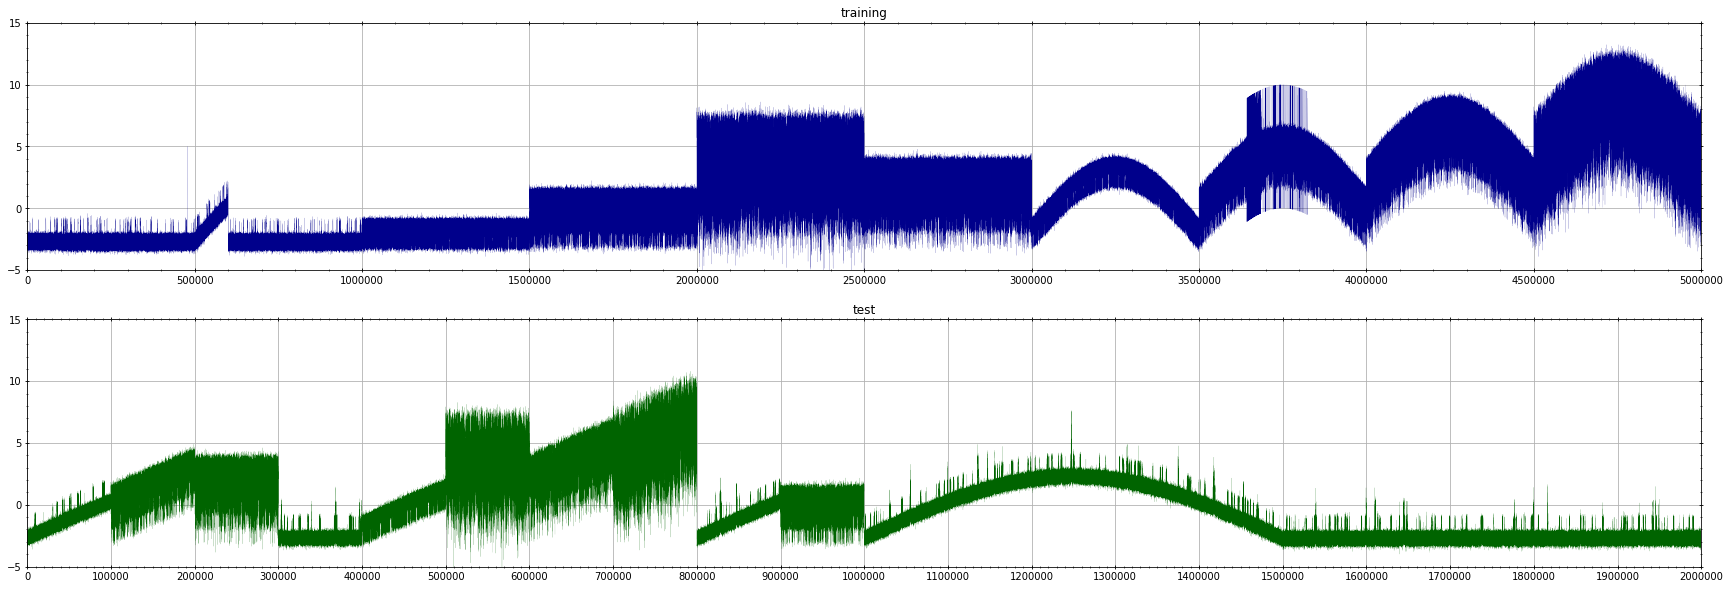

In [4]:
fig, axes = create_axes_grid(1,2,30,5)
set_axes(axes[0], x_val=[0,5000000,500000,100000], y_val=[-5,15,5,1])
axes[0].plot(df_train['signal'], color='darkblue', linewidth=.1);
axes[0].set_title('training')
set_axes(axes[1], x_val=[0,2000000,100000,10000], y_val=[-5,15,5,1])
axes[1].set_title('test')
axes[1].plot(df_test['signal'], color='darkgreen', linewidth=.1);

Visual identification can easily determine a) the signal group and b) whether there is a drift:

In [5]:
train_segm_separators = np.concatenate([[0,500000,600000], np.arange(1000000,5000000+1,500000)])
train_segm_signal_groups = [0,0,0,1,2,4,3,1,2,3,4] # from visual identification
train_segm_is_shifted = [False, True, False, False, False, False, False, True, True, True, True] # from visual identification
train_signal = np.split(df_train['signal'].values, train_segm_separators[1:-1])
train_opench = np.split(df_train['open_channels'].values, train_segm_separators[1:-1])

In [6]:
test_segm_separators = np.concatenate([np.arange(0,1000000+1,100000), [1500000,2000000]])
test_segm_signal_groups = [0,2,3,0,1,4,3,4,0,2,0,0] # from visual id
test_segm_is_shifted = [True, True, False, False, True, False, True, True, True, False, True, False] # from visual id
test_signal = np.split(df_test['signal'].values, test_segm_separators[1:-1])

The training data segments 0,3,4,6,5 are the "model segments" for the signal groups 0-5, respectively (clean & no shift):

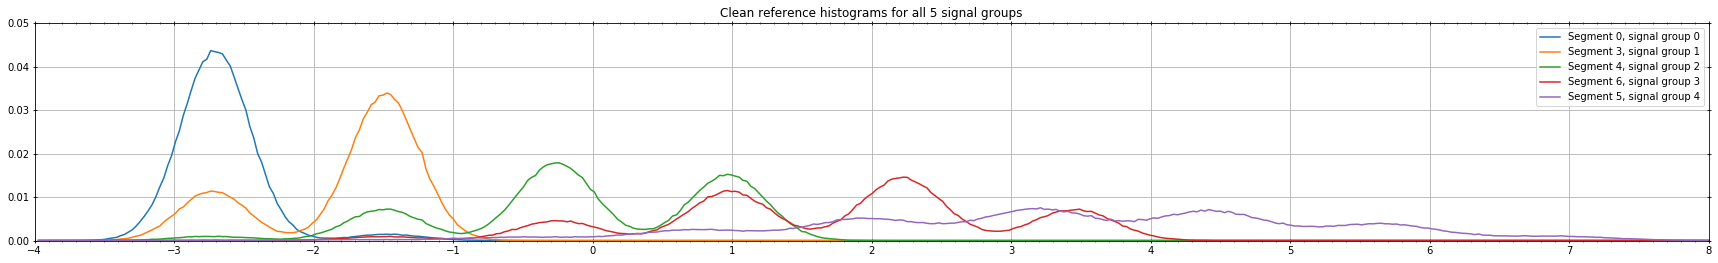

In [7]:
#create clean signal histograms
fig, axes = create_axes_grid(1,1,30,4)
set_axes(axes, x_val=[-4,8,1,.1], y_val=[0,0.05,0.01,0.01])

clean_hist = []
hist_bins = np.linspace(-4,10,500)

for j,i in enumerate([0,3,4,6,5]):
    clean_hist.append(np.histogram(train_signal[i], bins=hist_bins)[0])
    clean_hist[-1] = clean_hist[-1] / 500000 # normalize histogram
    axes.plot(hist_bins[1:], clean_hist[-1], label='Segment '+str(i)+', signal group '+str(j));
axes.legend();
axes.set_title("Clean reference histograms for all 5 signal groups");

Let's take a look at the linear shift in segment 1 and compare the histogram of 4 slices of width 1000 (at 0,25000,50000 and 75000) to the clean histogram of segment 0:

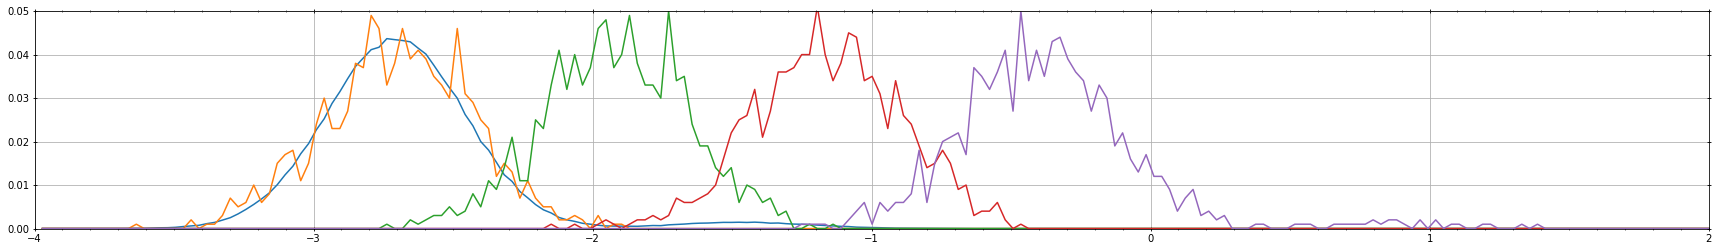

In [8]:
window_size = 1000

fig, axes = create_axes_grid(1,1,30,4)
set_axes(axes, x_val=[-4,2,1,.1], y_val=[0,0.05,0.01,0.01])

axes.plot(hist_bins[1:], clean_hist[0]);
for i in [0,25000,50000,75000]:
    window_hist = np.histogram(train_signal[1][i:i+window_size], bins=hist_bins)[0] / window_size
    axes.plot(hist_bins[1:], window_hist);

It's visually clear that the shift can be determined by matching the window histograms to the clean histogram. Now we need to do this automatically for all shifted data segments:

In [9]:
window_size = 1000
bin_width = np.diff(hist_bins)[0]
s_window = 10 # maximum absolute change in shift from window to window+1
train_signal_shift = []

for clean_id in range(len(train_segm_signal_groups)):
    
    group_id = train_segm_signal_groups[clean_id]
    window_shift = []
    prev_s = 0 # all signal groups start with shift=0
    window_data = train_signal[clean_id].reshape(-1,window_size)
    
    for w in window_data:
        window_hist = np.histogram(w, bins=hist_bins)[0] / window_size
        window_corr = np.array([ np.sum(clean_hist[group_id] * np.roll(window_hist, -s)) for s in range(prev_s-s_window, prev_s+s_window+1) ])
        prev_s = prev_s + np.argmax(window_corr) - s_window
        window_shift.append(-prev_s * bin_width)

    window_shift = np.array(window_shift)
    train_signal_shift.append(window_shift)    

This results in an already quite clean shift signal:

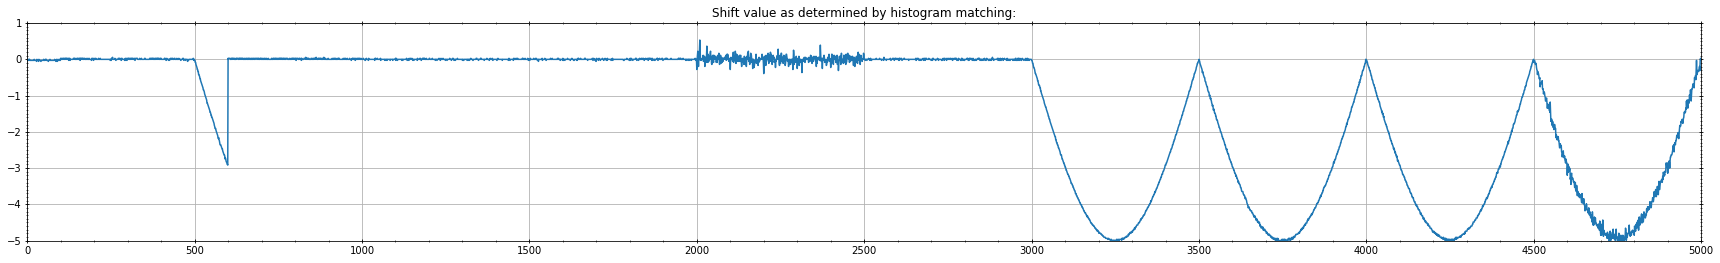

In [10]:
fig, axes = create_axes_grid(1,1,30,4)
set_axes(axes, x_val=[0,5000,500,100], y_val=[-5,1,1,.1])
axes.plot(np.concatenate(train_signal_shift));
axes.set_title("Shift value as determined by histogram matching:");

Finally, approximation by a 4th order polynomial:

In [11]:
train_signal_shift_clean = []
train_signal_detrend = []

for data, use_fit, signal in zip(train_signal_shift, train_segm_is_shifted, train_signal):
    if use_fit:
        data_x = np.arange(len(data), dtype=float) * window_size + window_size/2
        fit = np.flip(np.polyfit(data_x, data, 4))
        data_x = np.arange(len(data) * window_size, dtype=float)
        data_2 = np.sum([ c * data_x ** i for i, c in enumerate(fit) ], axis=0)
    else:
        data_2 = np.zeros(len(data) * window_size, dtype=float)
        
    train_signal_shift_clean.append(data_2)
    train_signal_detrend.append(signal + data_2)

The final shift and the cleaned signal:

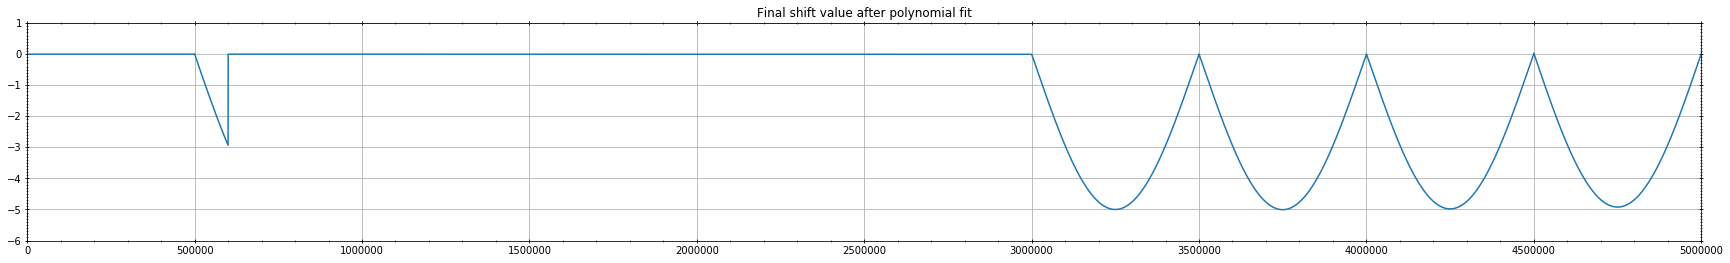

In [12]:
fig, axes = create_axes_grid(1,1,30,4)
set_axes(axes, x_val=[0,5000000,500000,100000], y_val=[-6,1,1,.1])
axes.plot(np.concatenate(train_signal_shift_clean));
axes.set_title("Final shift value after polynomial fit");

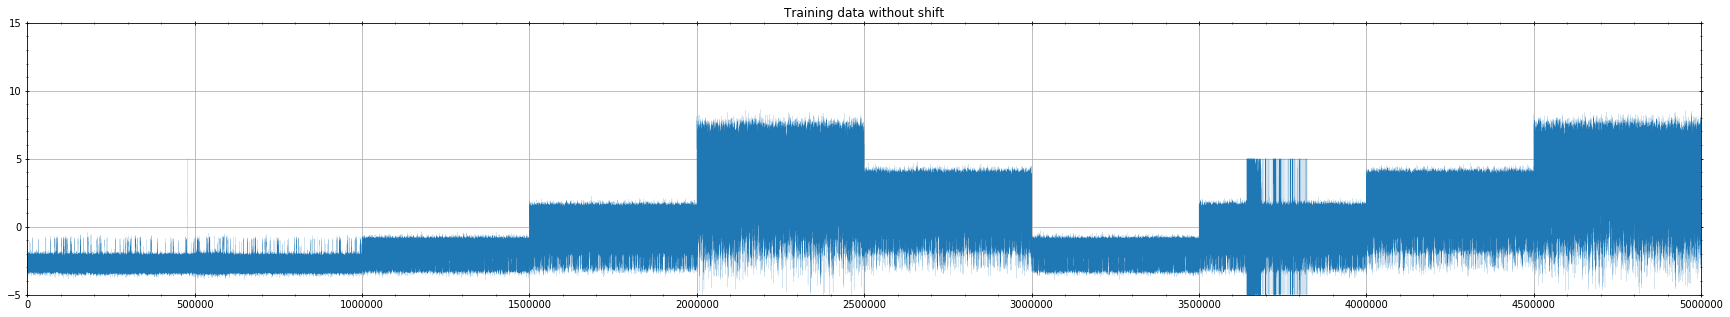

In [13]:
fig, axes = create_axes_grid(1,1,30,5)
set_axes(axes, x_val=[0,5000000,500000,100000], y_val=[-5,15,5,1])
axes.plot(np.concatenate(train_signal_detrend), linewidth=.1);
axes.set_title("Training data without shift");

And the same procedure for the test data:

In [14]:
window_size = 1000
bin_width = np.diff(hist_bins)[0]
s_window = 10
test_signal_detrend = []
test_signal_shift = []

for clean_id in range(len(test_segm_signal_groups)):
    
    group_id = test_segm_signal_groups[clean_id]
    window_shift = []
    prev_s = 0
    window_data = test_signal[clean_id].reshape(-1,window_size)
    
    for w in window_data:
        window_hist = np.histogram(w, bins=hist_bins)[0] / window_size
        window_corr = np.array([ np.sum(clean_hist[group_id] * np.roll(window_hist, -s)) for s in range(prev_s-s_window, prev_s+s_window+1) ])
        prev_s = prev_s + np.argmax(window_corr) - s_window
        window_shift.append(-prev_s * bin_width)

    window_shift = np.array(window_shift)
    test_signal_shift.append(window_shift)    

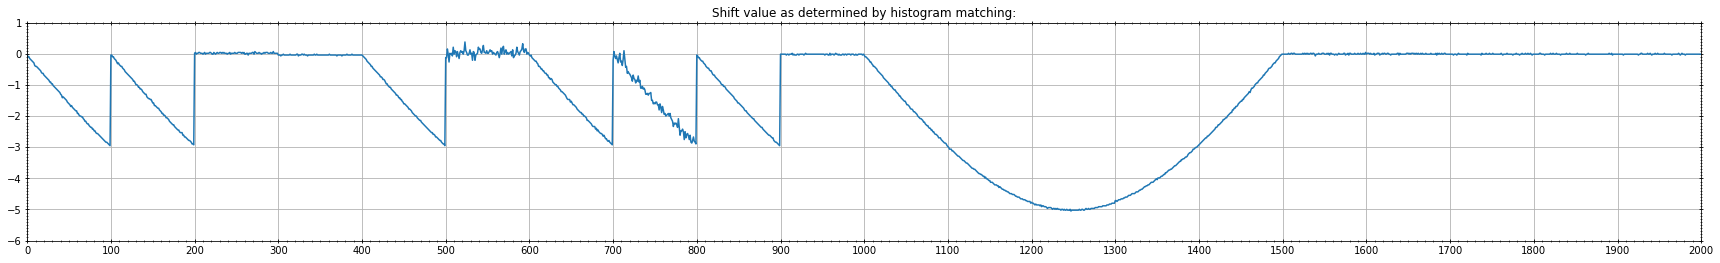

In [15]:
fig, axes = create_axes_grid(1,1,30,4)
set_axes(axes, x_val=[0,2000,100,10], y_val=[-6,1,1,.1])
axes.plot(np.concatenate(test_signal_shift));
axes.set_title("Shift value as determined by histogram matching:");

In [16]:
test_signal_shift_clean = []
test_signal_detrend = []
test_remove_shift = [True, True, False, False, True, False, True, True, True, False, True, False]

for data, use_fit, signal in zip(test_signal_shift, test_segm_is_shifted, test_signal):
    if use_fit:
        data_x = np.arange(len(data), dtype=float) * window_size + window_size/2
        fit = np.flip(np.polyfit(data_x, data, 4))
        data_x = np.arange(len(data) * window_size, dtype=float)
        data_2 = np.sum([ c * data_x ** i for i, c in enumerate(fit) ], axis=0)
    else:
        data_2 = np.zeros(len(data) * window_size, dtype=float)
        
    test_signal_shift_clean.append(data_2)
    test_signal_detrend.append(signal + data_2)

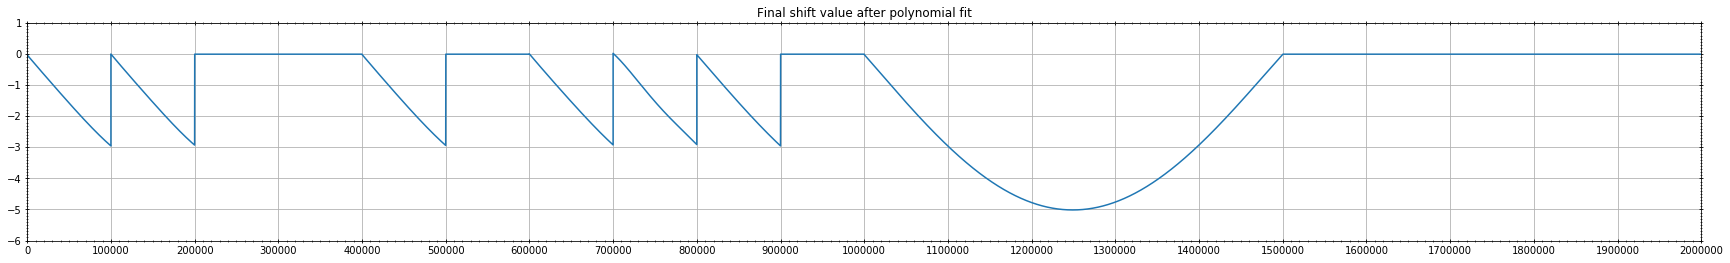

In [17]:
fig, axes = create_axes_grid(1,1,30,4)
set_axes(axes, x_val=[0,2000000,100000,10000], y_val=[-6,1,1,.1])
axes.plot(np.concatenate(test_signal_shift_clean));
axes.set_title("Final shift value after polynomial fit");

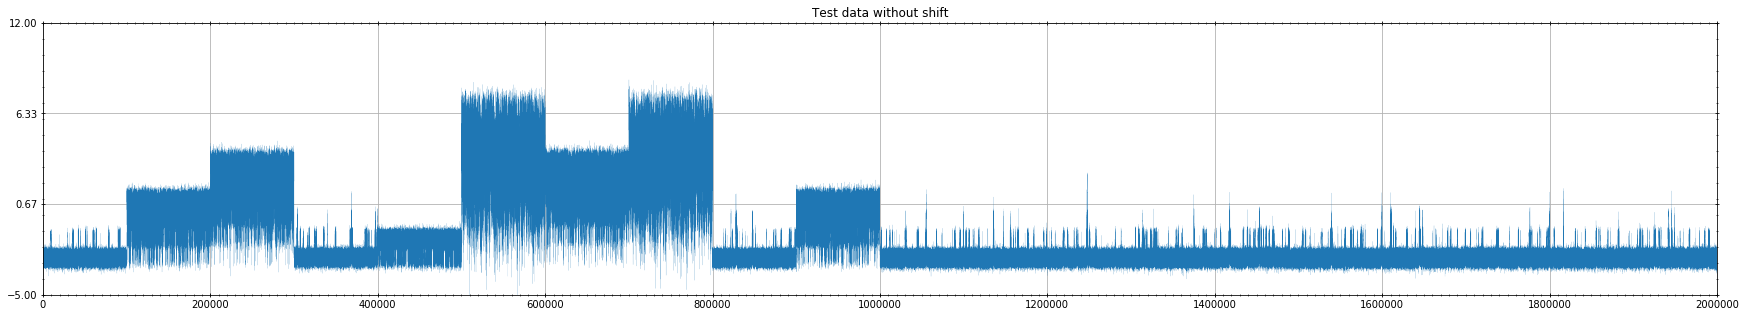

In [18]:
fig, axes = create_axes_grid(1,1,30,5)
set_axes(axes, x_val=[0,2000000,200000,10000], y_val=[-5,12,5,1])
axes.plot(np.concatenate(test_signal_detrend), linewidth=.1);
axes.set_title("Test data without shift");

Finally, save all info in a convenient format (I like this more than csv, but otherwise just use a pandas DataFrame):

In [19]:
import gc
gc.collect()

train = pd.DataFrame({'signal': np.concatenate(train_signal_detrend), 'channel': np.concatenate(train_opench)})
test = pd.DataFrame({'signal': np.concatenate(test_signal_detrend)})

train.to_csv('train.csv', index = False)
test.to_csv('test.csv', index = False)

In [20]:
train['time'] = df_train['time']
test['time'] = df_test['time']

In [21]:
def df_process(train, test, period = [30, 60, 90], n_classes = 11, LEN_ = 4000):

  gc.collect()

  train_mean = train.signal.mean()
  train_sigma = train.signal.std()

  train['signal'] = (train['signal'] - train_mean)/train_sigma
  test['signal'] = (test['signal'] - train_mean)/train_sigma

  train['group'] = train['time'].apply(lambda x: np.ceil(x*10000/500000))
  test['group'] = test['time'].apply(lambda x: np.ceil(x*10000/500000))

  for num in period:
    train[f'signal_{num}_lag'] = train[['group', 'signal']].groupby('group').shift(periods = num, fill_value=0).signal
    train[f'signal_{num}_lead'] = train[['group', 'signal']].groupby('group').shift(periods = -num, fill_value=0).signal

  for num in period:
    test[f'signal_{num}_lag'] = test[['group', 'signal']].groupby('group').shift(periods = num, fill_value=0).signal
    test[f'signal_{num}_lead'] = test[['group', 'signal']].groupby('group').shift(periods = -num, fill_value=0).signal

  train_signal = train[['signal'] + ['signal_' + str(x) + '_lag' for x in period] + ['signal_' + str(x) + '_lead' for x in period]].values.reshape(-1, LEN_, len(period)*2 + 1)
  test_signal = train[['signal'] + ['signal_' + str(x) + '_lag' for x in period] + ['signal_' + str(x) + '_lead' for x in period]].values.reshape(-1, LEN_, len(period)*2 + 1)

  train_target = pd.get_dummies(train['channel']).values.reshape(-1, LEN_, n_classes)
  return(train_signal, train_target, test_signal)

train_signal, train_target, test_signal = df_process(train, test)

In [22]:
np.save("train_signal.npy", train_signal)
np.save("train_target.npy", train_target)
np.save("test_signal.npy", test_signal)

In [23]:
# np.savez_compressed("train_detrend.npz", train_signal=train_signal_detrend, train_opench=train_opench, train_groups=train_segm_signal_groups)

In [24]:
# np.savez_compressed("test_detrend.npz", test_signal=test_signal_detrend, test_groups=test_segm_signal_groups)